![](header.jpg)

# Fisheye Lens Calibration

Kevin Walchko, Phd

20 Feb 2021

---


## References

- Medium: [Calibration Fisheye Lens Using OpenCV](https://medium.com/@kennethjiang/calibrate-fisheye-lens-using-opencv-333b05afa0b0)

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
from glob import glob
from opencv_camera import mosaic
from opencv_camera import UnDistort

In [2]:
CHECKERBOARD = (6,9)

objp = np.zeros((1, CHECKERBOARD[0]*CHECKERBOARD[1], 3), np.float32)
objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)

objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

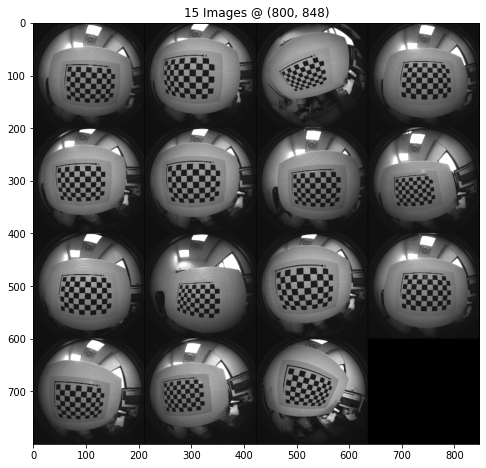

In [4]:
files = glob('../../large_dataset/stereo-fisheye/*.png')

imgs = [cv2.imread(f, 0) for f in files]
shape = imgs[0].shape

plt.subplots(1,1,figsize=(8,8))
plt.imshow(mosaic(imgs,4), cmap="gray")
plt.title(f"{len(imgs)} Images @ {shape}");

In [95]:
for im in imgs:
    ok, corners = cv2.findChessboardCorners(
        im, 
        CHECKERBOARD, 
        cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)
    
    if ok:
        objpoints.append(objp)
        cv2.cornerSubPix(
            im, 
            corners, 
            (3,3), 
            (-1,-1), 
            criteria=(cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 0.01)
        )
        imgpoints.append(corners)

In [209]:
flags = 0
flags |= cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC
flags |= cv2.fisheye.CALIB_CHECK_COND
flags |= cv2.fisheye.CALIB_FIX_SKEW

rms, K, D, rvecs, tvecs = cv2.fisheye.calibrate(
    objpoints,
    imgpoints,
    shape[::-1],
    None, # K
    None, # Distortion
    flags=calibration_flags,
#     criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6)
)

"""
K=np.array([[286.221588134766, 0.0,  419.467010498047], 
[0.0, 287.480102539062, 386.97509765625], 
[0.0, 0.0, 1.0]])

D=np.array([[-0.0043481751345098], 
[0.037125650793314], 
[-0.0355393998324871], 
[0.00577297387644649 ]])
"""
print(f"K:\n{K}")
print(f"D:\n {D.ravel()}")
print(f"RMS error: {rms:0.3f} px")

K:
[[289.439   0.    429.533]
 [  0.    290.739 403.567]
 [  0.      0.      1.   ]]
D:
 [-0.021  0.095 -0.134  0.06 ]
RMS error: 0.259 px


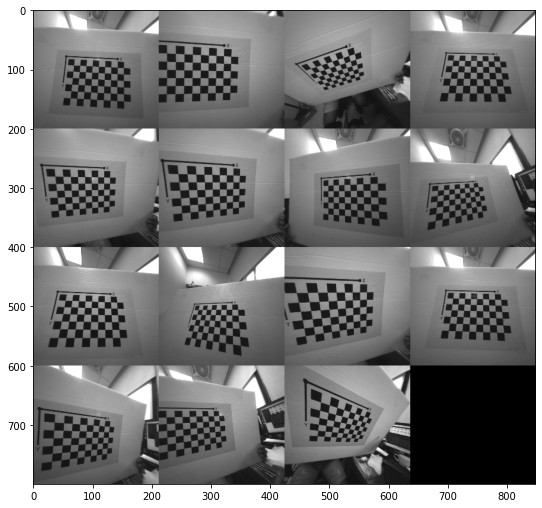

In [216]:
def fixme(img,K,D):
    DIM = img.shape[::-1]
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), K, DIM, cv2.CV_32FC1)
    return cv2.remap(img, map1, map2,
                     interpolation=cv2.INTER_LINEAR,borderMode=cv2.BORDER_CONSTANT)

uf = [fixme(i,K,D) for i in imgs]
ufix = mosaic(uf, 4)
plt.subplots(1,1,figsize=(9,9))
plt.imshow(ufix, cmap="gray");

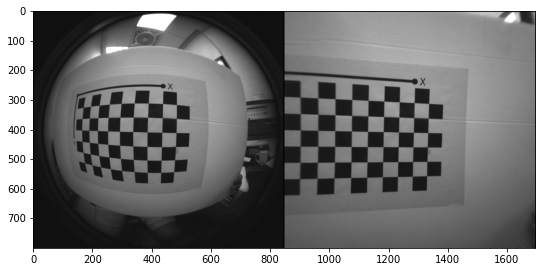

In [163]:
im = imgs[1]
ufix = fixme(im,K,D)
plt.subplots(1,1,figsize=(9,9))
plt.imshow(np.hstack((im,ufix)), cmap="gray");

(400, 424) 255


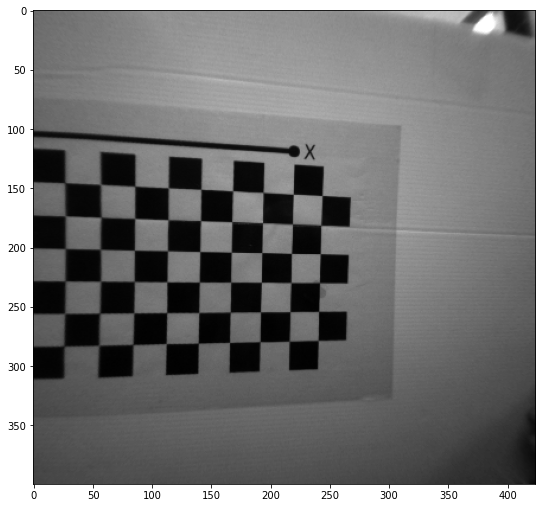

In [176]:
r,c = im.shape[:2]
Knew = K/2
Knew[2,2] = 1

# function is broken ... you HAVE to give it a second K 
# value or you get a completely black image 
u = cv2.fisheye.undistortImage(im,K,D,None,Knew,(c//2,r//2))
print(u.shape, np.max(u))
plt.subplots(1,1,figsize=(9,9))
plt.imshow(u, cmap="gray");

[[289.439   0.    429.533]
 [  0.    290.739 403.567]
 [  0.      0.      1.   ]] 
 [[109.357   0.    434.18 ]
 [  0.    109.848 406.28 ]
 [  0.      0.      1.   ]]


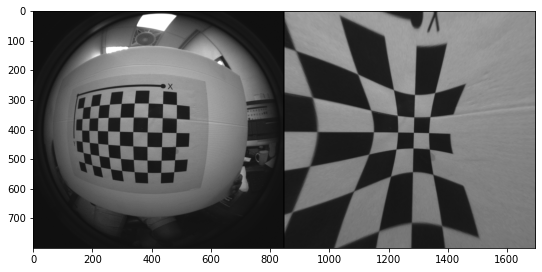

In [215]:
# this is completely BROKEN
im = imgs[1]
knew = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(
    K, D, im.shape[::-1], np.eye(3), balance=0.5)
print(K, "\n", knew)
ufix = fixme(im,knew,D)
plt.subplots(1,1,figsize=(9,9))
plt.imshow(np.hstack((im,ufix)), cmap="gray");